# USW-AI-Projekt: Einfluss sozialer Medien auf Aktienkurse
## CRISP-DM Struktur
---

### 1. Business Understanding
- Ziel: Zusammenhang zwischen Twitter-Stimmung und Aktienkursentwicklung untersuchen
- Zielgruppe: Finanzanalysten, Anleger
- Fragestellung: Kann man Kursbewegungen durch Stimmung erklären oder sogar vorhersagen?

### 2. Data Understanding
- Datenquellen: Twitter API v2, yfinance
- Zeitraum: z. B. letzte 3–6 Monate
- Unternehmen: z. B. SAP, Siemens, BMW

- Daten vorbereiten & alle nötigen Libaries laden


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stat

%matplotlib inline
sns.set()

# To avoid Warning message inbetween ...
import warnings
warnings.filterwarnings('ignore')

### 3. Data Preparation
- Dataset laden
- Hier werden die .csv-Dateien geladen:
- Tweets.csv enthält Tweets über Tesla (z. B. Datum, Text, Sentiment)

In [4]:
import pandas as pd

company_tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Company_Tweet.csv")
tweet         = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")
company       = pd.read_csv("../Datasets/raw/tweets_top_companies/Company.csv")
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")


### 4. Merge Data
- Daten zusammenführen
- Jetzt sind für jeden Tag Kursdaten + Durchschnittssentiment in einer gemeinsamen Tabelle

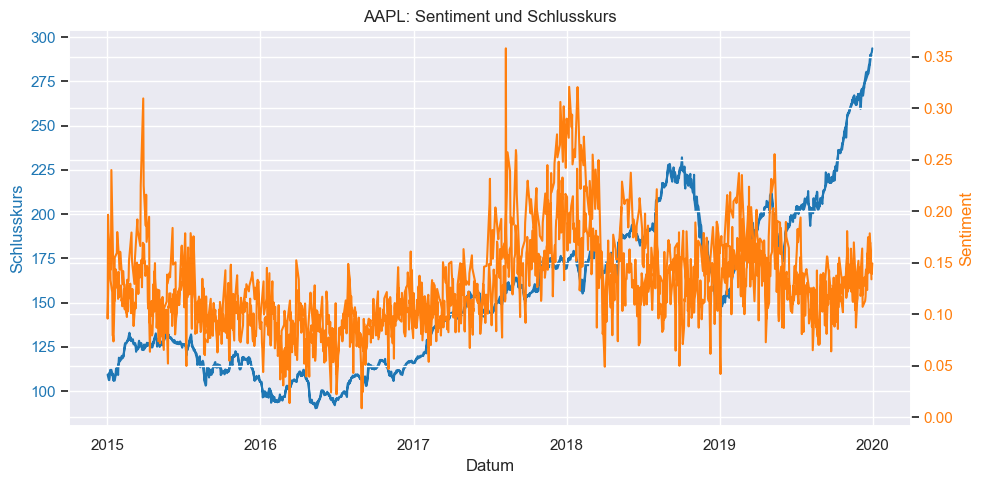

In [16]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Funktion: Sentiment + Kursdaten mergen
def merge_sentiment_and_stock_data(company_df, tweet_df):
    """
    Führt Kursdaten und Twitter-Sentimentdaten für alle Ticker-Symbole zusammen.

    Args:
        company_df (pd.DataFrame): Kursdaten mit Spalten 'ticker_symbol', 'day_date', ...
        tweet_df (pd.DataFrame): Tweets mit Spalten 'ticker_symbol', 'post_date', 'body'

    Returns:
        dict: Key = Ticker (z. B. 'AAPL'), Value = gemergter DataFrame (Kurs + Sentiment)
    """

    # Datumsformate vereinheitlichen
    company_df['day_date'] = pd.to_datetime(company_df['day_date'])
    tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s', errors='coerce')
    tweet_df = tweet_df.dropna(subset=['post_date'])

    # Prüfen ob 'ticker_symbol' vorhanden ist
    if 'ticker_symbol' not in tweet_df.columns:
        raise ValueError(f"'ticker_symbol' fehlt in tweet_df. Vorhandene Spalten: {tweet_df.columns.tolist()}")

    # Sentiment berechnen
    analyzer = SentimentIntensityAnalyzer()
    tweet_df['sentiment_score'] = tweet_df['body'].apply(
        lambda x: analyzer.polarity_scores(str(x))['compound']
    )

    result = {}

    for ticker in company_df['ticker_symbol'].unique():
        comp = company_df[company_df['ticker_symbol'] == ticker].copy()
        tw = tweet_df[tweet_df['ticker_symbol'] == ticker].copy()

        if tw.empty or comp.empty:
            continue

        # Ø-Sentiment pro Tag berechnen
        tw['Date'] = tw['post_date'].dt.normalize()
        daily_sentiment = tw.groupby('Date')['sentiment_score'].mean().reset_index()

        # Kursdaten auf Zeitraum der Tweets beschränken
        start, end = tw['post_date'].min(), tw['post_date'].max()
        comp = comp[(comp['day_date'] >= start) & (comp['day_date'] <= end)]

        # Merge durchführen
        merged = pd.merge(
            comp,
            daily_sentiment,
            left_on='day_date',
            right_on='Date',
            how='inner'
        )

        result[ticker] = merged

    return result

# Funktion: Visualisierung
def plot_sentiment_vs_stock(df, ticker):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_title(f"{ticker}: Sentiment und Schlusskurs")
    ax1.set_xlabel("Datum")
    ax1.set_ylabel("Schlusskurs", color="tab:blue")
    ax1.plot(df['day_date'], df['close_value'], color="tab:blue", label="Close Value")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Sentiment", color="tab:orange")
    ax2.plot(df['day_date'], df['sentiment_score'], color="tab:orange", label="Sentiment")
    ax2.tick_params(axis='y', labelcolor="tab:orange")

    fig.tight_layout()
    plt.show()

# CSV-Dateien laden
company_value = pd.read_csv("../Datasets/raw/company_values/CompanyValues.csv")
tweet = pd.read_csv("../Datasets/raw/tweets_top_companies/Tweet.csv")

# Hinweis: Hier ist der Fehler entstanden. tweet_df braucht eine Spalte 'ticker_symbol'.
# Wenn diese fehlt, musst du sie ggf. aus einer anderen Spalte erzeugen oder zu Testzwecken setzen:
# Beispiel (wenn du nur einen Ticker testest wie 'AAPL'):
tweet['ticker_symbol'] = 'AAPL'  # Entferne oder ersetze dies später durch korrekte Daten

# Merge durchführen
merged_data = merge_sentiment_and_stock_data(company_value, tweet)

# Beispielplot für AAPL
plot_sentiment_vs_stock(merged_data['AAPL'], 'AAPL')


### 5. Korrelation berechnen
- Korrelation zeigt, ob positive Tweets mit steigenden Kursen einhergehen (+1 = stark positiv)

In [26]:
print(merged_df[['sentiment_score', 'close_value']].isnull().sum())


sentiment_score    0
close_value        0
dtype: int64


In [15]:
correlation = merged_df[['sentiment_score', 'close_value']].corr()
print("📊 Korrelation zwischen Sentiment und Schlusskurs:")
print(correlation)

📊 Korrelation zwischen Sentiment und Schlusskurs:
                 sentiment_score  close_value
sentiment_score              NaN          NaN
close_value                  NaN          NaN


### 6.Visualisierung

Die Entwicklung des Aktienkurses von Tesla (Close-Preis)
Den durchschnittlichen Sentiment-Wert pro Tag (z. B. aus Twitter-Daten)

In [ ]:
import matplotlib.pyplot as plt

# x-Achse = Datum, y-Achse = Schlusskurs (Close) der Tesla-Aktie, durchschnittliches Sentiment pro Tag (multipliziert mit 100, um auf ähnlicher Skala wie Aktienkurs sichtbar zu sein)
plt.figure(figsize=(12,5)) # Diagramm mit einer Größe von 12 x 5
plt.plot(merged_df['Date'], merged_df['Close'], label='Schlusskurs', color='blue')
plt.plot(merged_df['Date'], merged_df['Avg_Sentiment'] * 100, label='Sentiment (x100)', color='orange')

plt.legend()
plt.title("Tesla: Sentiment vs. Aktienkurs")
plt.xlabel("Datum")
plt.ylabel("Wert")
plt.grid(True)
plt.show()


📌 Zeigt die Verteilung der Sentiment-Scores (z. B. wie viele Tweets sind stark negativ, positiv oder neutral).

In [ ]:
column_distplot(tweet_df, column_name="afinn_score", bins=10)
column_distplot(tweet_df, column_name="vander_score", bins=10)


🔹 2. Liniendiagramm: Sentiment vs. Aktienkurs über Zeit

📌 Visualisiert zeitlich: Wann starke positive oder negative Tweets auftraten und wie sich der Aktienkurs parallel dazu veränderte.



In [ ]:
def sentiment_overtime(tweet_df, stock_df, title, score_column_name="score"):
    fig = plt.figure(figsize=(24,10))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()

    # Sentiment (Vader oder Afinn)
    ax1.vlines(tweet_df['day_date'], 0, tweet_df[score_column_name])
    ax1.axhline(y=0, color='r', linestyle='-')

    # Aktienkurs (Close)
    ax2.plot(stock_df['day_date'], stock_df['close_value'], color='orange', label='Stock price')

    ax2.set_title("Effects of " + title +" tweets to stock price")
    ax1.set_xlabel('Datum')
    ax1.set_ylabel('Sentiment Score', color="blue")
    plt.show()
